In [1]:
# Importing required packages.
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam
import tensorflow.keras.backend as K
from matplotlib import pyplot

In [2]:
# Checking that Tensorflow has access to the GPU power.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Reading all dataframes needed for modeling.
X_train = pd.read_pickle("../preprocessing/X_train.pkl")
X_val = pd.read_pickle("../preprocessing/X_val.pkl")
X_test = pd.read_pickle("../preprocessing/X_test.pkl")
y_train = pd.read_pickle("../preprocessing/y_train.pkl")
y_val = pd.read_pickle("../preprocessing/y_val.pkl")
y_test = pd.read_pickle("../preprocessing/y_test.pkl")

In [4]:
# Defining custom MSE function.
def custom_mse(y_true,y_pred):
   
    index = 4
    alpha = 0.75
   
    ncol = y_true.shape[1]
    alpha1 = alpha
    alpha0 = (1-alpha)/(ncol-1.0)

    loss = K.square(y_pred-y_true)

    weights = []
    for i in range(ncol):
        if (i == index):
            weights.append(alpha1)
        else: 
            weights.append(alpha0)

    loss = loss * weights

    return K.mean(K.sum(loss, axis=1))

In [5]:
# Defining the Keras model.
model = Sequential()
model.add(Dense(16, input_dim=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(16, activation='linear'))

opt = Nadam(learning_rate=0.0003, clipnorm=1.0)

model.compile(loss=custom_mse, optimizer=opt, metrics=custom_mse)

Metal device set to: NVIDIA GeForce GT 750M

systemMemory: 16.00 GB
maxCacheSize: 1.00 GB



2022-06-20 10:12:35.386046: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 10:12:35.386719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-20 10:12:35.386934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Inspecting the model structure.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1616      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [7]:
# Defining simple early stopping criterion.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Fitting the model.
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, verbose=0, callbacks=[es, mc], batch_size=250)

2022-06-20 10:12:38.149539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-20 10:13:04.471885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.43036, saving model to best_model.h5

Epoch 00002: val_loss improved from 1.43036 to 1.17847, saving model to best_model.h5

Epoch 00003: val_loss improved from 1.17847 to 1.04607, saving model to best_model.h5

Epoch 00004: val_loss improved from 1.04607 to 1.02085, saving model to best_model.h5

Epoch 00005: val_loss improved from 1.02085 to 0.99889, saving model to best_model.h5

Epoch 00006: val_loss improved from 0.99889 to 0.97177, saving model to best_model.h5

Epoch 00007: val_loss improved from 0.97177 to 0.94144, saving model to best_model.h5

Epoch 00008: val_loss improved from 0.94144 to 0.92092, saving model to best_model.h5

Epoch 00009: val_loss did not improve from 0.92092

Epoch 00010: val_loss improved from 0.92092 to 0.91345, saving model to best_model.h5

Epoch 00011: val_loss improved from 0.91345 to 0.91315, saving model to best_model.h5

Epoch 00012: val_loss improved from 0.91315 to 0.90322, saving model to best_mode

In [8]:
# Loading the saved model.
saved_model = load_model('best_model.h5', custom_objects={'custom_mse': custom_mse})

# Evaluating the model.
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Val: %.3f and Test: %.3f' % (train_acc, val_acc, test_acc))

2022-06-20 10:27:01.627020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train: 0.986, Val: 0.898 and Test: 0.863


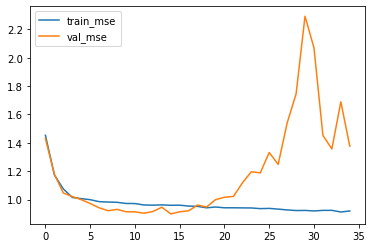

In [9]:
# Plotting training history.
pyplot.plot(history.history['loss'], label='train_mse')
pyplot.plot(history.history['val_loss'], label='val_mse')
pyplot.legend()
pyplot.show()